# Fitting

In [1]:
import sys
sys.path.insert(0, '../../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle as pkl
import tensorflow as tf

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from kraus_channels import KrausMap
from loss_functions import ProbabilityMSE, ProbabilityRValue, channel_fidelity_loss
from optimization import ModelSPAM, ModelQuantumMap, Logger, model_saver
from quantum_channel import DilutedChannel, ChoiMapStatic
from quantum_tools import apply_unitary, measurement, resample, state_fidelity
from experimental import counts_to_probs, generate_pauliInput_circuits, generate_pauli_circuits, marginalize_counts
from spam import SPAM, InitialState, POVMwQR as POVM, IdealPOVM, IdealInit, povm_fidelity, CorruptionMatrix, IdealSPAM
from synthetic_data import generate_spam_data, generate_map_data
from utils import saver, loader, train_val_split
from quantum_circuits import pqc_basic
from spectrum import channel_spectrum, complex_spacing_ratio, Spectrum, coat_spectrum, spectrum_to_angular, spectrum_to_radial
from qiskit.circuit.library import iSwapGate


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
def save_spectrum(spectrum, filename):
    csr_array = np.real(spectrum.get_spectrum(is_complex=False))
    np.savetxt(filename, csr_array)

def save_heatmap(heatmap, filename):
    n = heatmap.shape[0]
    grid = np.arange(n)
    x, y = np.meshgrid(grid, grid)

    heatmap = heatmap.flatten()
    x = x.flatten()
    y = y.flatten()

    data = np.array([x, y, heatmap]).T
    np.savetxt(filename, data)
    


## Retrieve CSR

### L = 5

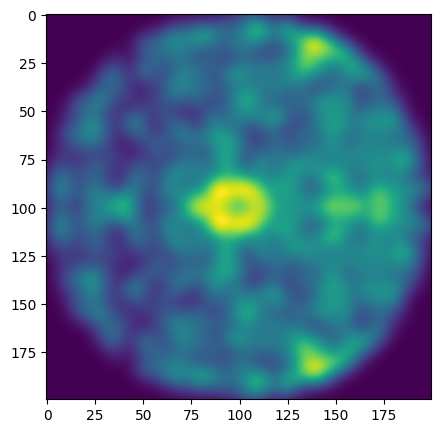

In [ ]:
n = 4

model_list = pkl.load(open(f'../models/integrable_model_{n}_L=5.model', 'rb'))

loss_list = []
spectrum_list = []
csr_integrable_list = []
for model in model_list:
    loss = model.logger.loss_list[0][-1]
    loss_list.append(loss)

    channel = model.channel
    spectrum = channel_spectrum(channel)
    csr = complex_spacing_ratio(spectrum)

    spectrum_list.append(spectrum)
    csr_integrable_list.append(csr)

csr_integrable = Spectrum(csr_integrable_list)
csr_integrable_coat = coat_spectrum(csr_integrable, sigma = 0.05, grid_size = 200)


fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_integrable_coat)
plt.savefig('figures/integrable_crs_retrieved_L=5.png')
plt.show()

In [31]:
save_spectrum(csr_integrable, 'book_keeping/integrable_crs_eigenvalues_L=5_retrieved.txt')
np.savetxt('book_keeping/integrable_crs_denstity_L=5_retrieved.txt',csr_integrable_coat)

## L = 10

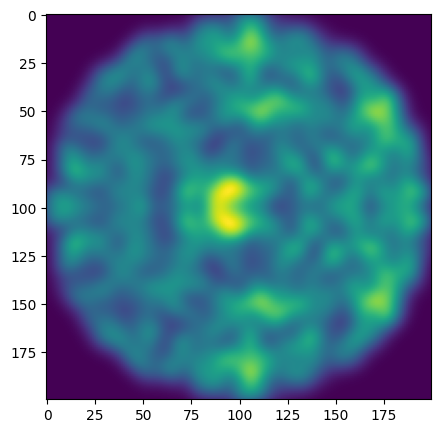

In [32]:
n = 4

model_list = pkl.load(open(f'../models/integrable_model_{n}_L=10.model', 'rb'))

loss_list = []
spectrum_list = []
csr_integrable_list = []
for model in model_list:
    loss = model.logger.loss_list[0][-1]
    loss_list.append(loss)

    channel = model.channel
    spectrum = channel_spectrum(channel)

    csr = complex_spacing_ratio(spectrum)

    spectrum_list.append(spectrum)
    csr_integrable_list.append(csr)

csr_integrable = Spectrum(csr_integrable_list)

csr_integrable_coat = coat_spectrum(csr_integrable, sigma = 0.05, grid_size = 200)

fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_integrable_coat)
plt.savefig('figures/integrable_crs_retrieved_L=10.png')
plt.show()

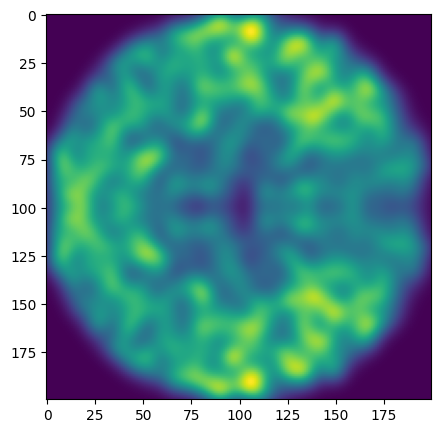

In [33]:
n = 4

model_list = pkl.load(open(f'../models/integrable_model_{n}_L=30_reorder.model', 'rb'))

loss_list = []
spectrum_list = []
csr_integrable_list = []
for model in model_list:
    loss = model.logger.loss_list[0][-1]
    loss_list.append(loss)

    channel = model.channel
    spectrum = channel_spectrum(channel)

    csr = complex_spacing_ratio(spectrum)

    spectrum_list.append(spectrum)
    csr_integrable_list.append(csr)

csr_integrable = Spectrum(csr_integrable_list)
save_spectrum(csr_integrable, 'book_keeping/integrable_crs_L=30.txt')

csr_integrable_coat = coat_spectrum(csr_integrable, sigma = 0.05, grid_size = 200)
save_heatmap(csr_integrable_coat, 'book_keeping/integrable_crs_L=30_heatmap.txt')

fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_integrable_coat)
plt.savefig('figures/integrable_crs_retrieved_L=30.png')
plt.show()

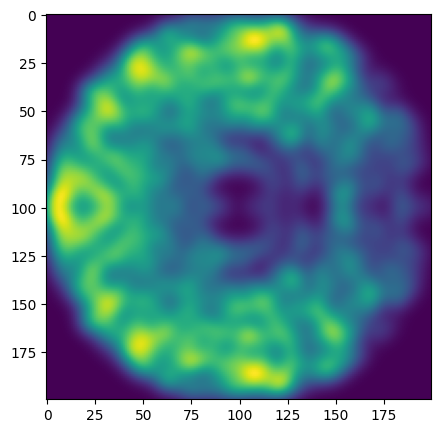

In [21]:
n = 4

model_list = pkl.load(open(f'../models/integrable_model_{n}_L=50_reorder.model', 'rb'))

loss_list = []
spectrum_list = []
csr_integrable_list = []
for model in model_list:
    loss = model.logger.loss_list[0][-1]
    loss_list.append(loss)

    channel = model.channel
    spectrum = channel_spectrum(channel)

    csr = complex_spacing_ratio(spectrum)

    spectrum_list.append(spectrum)
    csr_integrable_list.append(csr)

csr_integrable = Spectrum(csr_integrable_list)
save_spectrum(csr_integrable, 'book_keeping/integrable_crs_L=50.txt')

csr_integrable_coat = coat_spectrum(csr_integrable, sigma = 0.05, grid_size = 200)

fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_integrable_coat)
plt.savefig('figures/integrable_crs_retrieved_L=50.png')
plt.show()

## Non-Integrable

(200, 200)


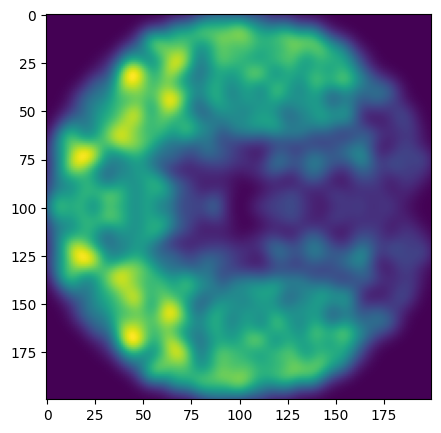

In [5]:
n = 4

model_list = pkl.load(open(f'../models/nonintegrable_model_{n}_L=10.model', 'rb'))

loss_list = []
spectrum_list = []
csr_nonintegrable_list = []
for model in model_list:
    loss = model.logger.loss_list[0][-1]
    loss_list.append(loss)

    channel = model.channel
    spectrum = channel_spectrum(channel)

    csr = complex_spacing_ratio(spectrum)

    spectrum_list.append(spectrum)
    csr_nonintegrable_list.append(csr)

csr_nonintegrable = Spectrum(csr_nonintegrable_list)
csr_nonintegrable_coat = coat_spectrum(csr_nonintegrable, sigma = 0.05, grid_size = 200)

print(csr_nonintegrable_coat.shape)

fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_nonintegrable_coat)
plt.savefig('figures/nonintegrable_crs_retrieved_L=10.png')
plt.show()

In [7]:
save_spectrum(csr_nonintegrable, 'book_keeping/chaotic_crs_L=10.txt')
np.savetxt('book_keeping/chaotic_crs_denstity_L=10.txt', csr_nonintegrable_coat)

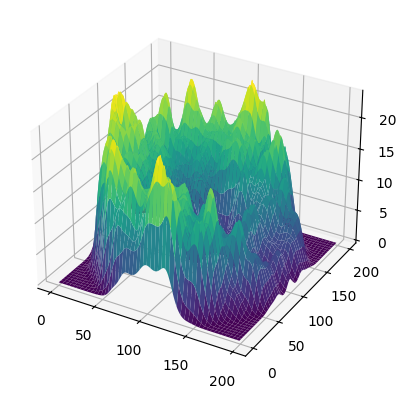

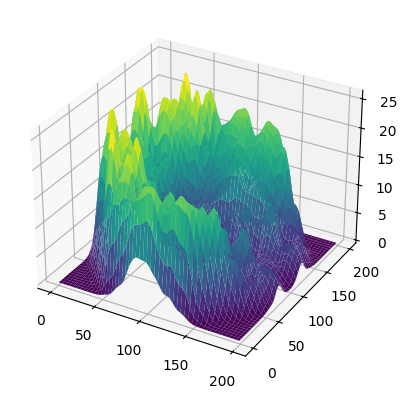

In [24]:
#3d surface plot of heatmap

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(200)
y = np.arange(200)
x, y = np.meshgrid(x, y)
z = csr_integrable_coat
ax.plot_surface(x, y, z, cmap='viridis')
#ax.set_zlim(0, 8000)
plt.show()

# set z axis to 0 to 700

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.arange(200)
y = np.arange(200)
x, y = np.meshgrid(x, y)
z = csr_nonintegrable_coat
ax.plot_surface(x, y, z, cmap='viridis')
#ax.set_zlim(0, 8000)
plt.show()

